In [ ]:
# Code implemented from : https://github.com/tansey/deep-dose-response/tree/master

"""Dose-Response Modeling in High-Throughput Cancer Drug Screenings: An end-to-end approach
W. Tansey, K. Li, H. Zhang, S. W. Linderman, D. M. Blei, R. Rabadan, and C. H. Wiggins
Preprint, December 2018. https://arxiv.org/abs/1812.05691"""

In [52]:
import os
import sys
import random
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import math
import seaborn as sns

from scipy.special import gammaln, gammaincc
from scipy.stats import gamma, poisson
from scipy.optimize import minimize
from scipy.stats import invwishart, poisson, multivariate_normal as mvn

In [8]:
raw_data = pd.read_csv("/content/GDSC2_public_raw_data_27Oct23.csv")
pos_ctrl_priors = np.load("/content/pos-ctrl-priors.npz")
neg_ctrl_priors = np.load("/content/neg-ctrl-priors.npz")

In [53]:
def ilogit(x):
    #print("Input to ilogit:", x, "Type:", type(x))  # Debugging line
    return 1. / (1 + np.exp(-x))

"""def monotone_rejection_sampler(m, Sigma):
    beta = np.random.multivariate_normal(m, Sigma)
    while np.any(beta[:-1] > beta[1:]):
        beta = np.random.multivariate_normal(m, Sigma)
    return beta"""

def monotone_rejection_sampler(m, Sigma, index=None):
    attempts = 0
    beta = np.random.multivariate_normal(m, Sigma)
    while np.any(beta[:-1] > beta[1:]):
        beta = np.random.multivariate_normal(m, Sigma)
        attempts += 1
    print(f"Row {index}: Completed after {attempts + 1} attempts")
    return beta

In [54]:
from logging import raiseExceptions
def elliptical_slice(xx, prior, log_like_fn, cur_log_like = None, angle_range = 0, ll_args = None, mu = None):
  xx = np.copy(xx)
  D = np.size(xx)
  print("xx size: ", np.shape(xx),
        "prior size: ", np.shape(prior))
  if np.size(prior) == D:
    nu = np.reshape(prior, (D,))
  else:
    if np.shape(prior)!=(D,D):
      raise Exception("Prior must be given by a D-element sample")
    nu = np.reshape(np.dot(prior, np.random.randn(D,1)).T, np.shape(xx))
  if mu is None:
    mu = np.zeros(D)
  elif np.size(mu)!=D:
    raise Exception("Speicifed mean does not have the correct shape")

  if (cur_log_like is None):
    #cur_log_like = log_like_fn(xx, ll_args)
    cur_log_like = log_like_fn(xx)
  init_ll = cur_log_like
  hh = np.log(np.random.rand()) + cur_log_like

  #set up the bracket of angles and pick first proposal
  # phi = theta' - theta is a change in angle
  if angle_range <= 0:
    phi = np.random.rand() * 2 * math.pi
    phi_min = phi - 2*math.pi
    phi_max = phi
  else:
    phi_min = -1 * angle_range * np.random.rand()
    phi_max = phi_min + angle_range
    phi = np.random.rand() * (phi_max - phi_min) + phi_min

  check=0
  while True:
    #compute xx for proposed angle difference and check if it's on the slice
    #Add the offset mu before computing the likelihood
    xx_prop = ((xx-mu)*np.cos(phi)) + nu*np.sin(phi) + mu
    #cur_log_like = log_like_fn(xx_prop, ll_args)
    cur_log_like = log_like_fn(xx_prop)
    """
    if check%20==0:
      print(f"Proposed beta: {xx_prop}, log likelihood: {cur_log_like}")
    """
    if cur_log_like >= hh:
      print(f"Accepted new beta")
      break

    #shrink slice to rejected point
    if phi>0:
      phi_max = phi
    elif phi < 0:
      phi_min = phi
    else:
      import warnings
      assert np.allclose(xx, xx_prop)
      warnings.warn("Shrug to current position and stil rejected")
      break

    phi = np.random.rand()*(phi_max - phi_min) + phi_min
    check+=1

  return xx_prop, cur_log_like

In [11]:
unique_barcodes = raw_data['BARCODE'].unique()

M = np.full((len(unique_barcodes), 7), np.nan)
Y = np.full((len(unique_barcodes), 7), np.nan)

for i, barcode in enumerate(unique_barcodes):
    barcode_data = raw_data[raw_data['BARCODE'] == barcode]

    # Iterate over each dose level (1 to 7)
    for dose_level in range(1, 8):
        # Build the TAG pattern for the current dose level
        tag_pattern = f'D{dose_level}-S'

        dose_data = barcode_data[barcode_data['TAG'].str.contains(tag_pattern, na=False)]

        if not dose_data.empty:
            M[i, dose_level - 1] = dose_data['CONC'].values[0]  # Concentration
            Y[i, dose_level - 1] = dose_data['INTENSITY'].values[0]  # Intensity


In [16]:
raw_barcodes = list(set(unique_barcodes))

In [12]:
M_df = pd.DataFrame(M, index=unique_barcodes, columns=[f'Dose_{i}' for i in range(1, 8)])
Y_df = pd.DataFrame(Y, index=unique_barcodes, columns=[f'Dose_{i}' for i in range(1, 8)])

M_df.index.name = 'BARCODE'
Y_df.index.name = 'BARCODE'

M_df.to_csv('/content/M_df.csv')
Y_df.to_csv('/content/Y_df.csv')

In [15]:
A = pos_ctrl_priors["a"]
B = pos_ctrl_priors["b"]
C = neg_ctrl_priors["c"]

In [125]:
drug_to_barcodes = raw_data.groupby('DRUG_ID')['BARCODE'].apply(list)

In [97]:
filtered_data = raw_data[raw_data['DRUG_ID'].notna()]

unique_barcodes_drug = filtered_data['BARCODE'].unique()


In [98]:
# subset 100 barcodes to check the code
selected_barcodes = np.random.choice(unique_barcodes_drug, 30, replace=False)
A_full = pd.DataFrame({'BARCODE': pos_ctrl_priors['barcodes'], 'A': pos_ctrl_priors['a']}).set_index('BARCODE')
B_full = pd.DataFrame({'BARCODE': pos_ctrl_priors['barcodes'], 'B': pos_ctrl_priors['b']}).set_index('BARCODE')
C_full = pd.DataFrame({'BARCODE': neg_ctrl_priors['barcodes'], 'C': neg_ctrl_priors['c']}).set_index('BARCODE')

A_subset = A_full.loc[selected_barcodes]
B_subset = B_full.loc[selected_barcodes]
C_subset = C_full.loc[selected_barcodes]

M_subset = M_df.loc[selected_barcodes]
M_subset.applymap(lambda x: round(x, 4))
Y_subset = Y_df.loc[selected_barcodes]


<ipython-input-98-d46252928dea>:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  M_subset.applymap(lambda x: round(x, 4))


In [99]:
def beta_mcmc(mu_hat, sigma_hat, a_prior, b_prior, c_prior, Y, BARCODE_list,
                nburn=500, nsamples=1000, nthin=1, **kwargs):
    np.set_printoptions(suppress=True, precision=2)
    print('Total BARCODEs:', len(BARCODE_list))

    Beta_samples = []
    Sigma_samples = []
    Loglikelihood_samples = []

    for barcode_idx, barcode in enumerate(BARCODE_list):
        print(f'Processing BARCODE {barcode} ({barcode_idx + 1} of {len(BARCODE_list)})')

        # Extract `a_prior`, `b_prior`, `c_prior`, and `Y` for the current BARCODE
        a = a_prior.loc[barcode, 'A']
        b = b_prior.loc[barcode, 'B']
        c = c_prior.loc[barcode, 'C']
        y_data = Y.loc[barcode].values

        print('a prior value: ', a,
              '\n b prior value: ', b,
              '\n c prior value: ', c,
              '\n intensity for this barcode: ', y_data)

        # Create lambda grid and weights for this BARCODE
        lam_grid = gamma.rvs(a=a, scale=b, size=100)  # Generate 100 lambda samples
        weights = gamma.pdf(lam_grid, a=a, scale=b)
        weights /= weights.sum()  # Normalize weights

        # Use the provided mu_hat and sigma_hat directly for the current BARCODE
        Mu = mu_hat[barcode_idx]  # Now accessing one BARCODE's mu_hat vector
        Sigma = sigma_hat  # Constant covariance matrix

        # Initialize Beta with Mu
        Beta = np.copy(Mu)

        # Prepare results arrays for this BARCODE
        barcode_Beta_samples = np.zeros((nsamples, len(Beta)))
        barcode_Sigma_samples = np.zeros((nsamples, Sigma.shape[0], Sigma.shape[1]))
        barcode_Loglikelihood_samples = np.zeros(nsamples)

        # Define log-likelihood function for the current BARCODE
        def log_likelihood(z):
            z = z[..., None]  # Expand for lambda grid
            lam = lam_grid[None, None]  # Room for z grid and multiple doses
            w = weights[None]
            y = y_data[None, :, None]
            result = np.nansum(np.log((poisson.pmf(y, ilogit(z) * lam + c) * w).clip(1e-10, np.inf).sum(axis=-1)), axis=-1)
            return result

        # Initialize log-likelihood for the initial Beta
        Cur_log_likelihood = log_likelihood(Beta)
        chol_Sigma = np.linalg.cholesky(Sigma)

        # Run MCMC sampling for this BARCODE
        for step in range(nburn + nsamples * nthin):
            print(f'MCMC step {step + 1}/{nburn + nsamples * nthin} for BARCODE {barcode}')

            # Apply elliptical slice sampling for Beta
            Beta, Cur_log_likelihood = elliptical_slice(
                Beta,
                chol_Sigma,               # Cholesky decomposition of Sigma
                log_likelihood,           # Log-likelihood function
                cur_log_like=Cur_log_likelihood,  # Current log likelihood
                mu=Mu                     # Mean vector for elliptical slice
            )

            # Save samples after burn-in and thinning
            if step >= nburn and ((step - nburn) % nthin) == 0:
                sample_idx = (step - nburn) // nthin
                barcode_Beta_samples[sample_idx] = Beta
                barcode_Sigma_samples[sample_idx] = Sigma
                barcode_Loglikelihood_samples[sample_idx] = Cur_log_likelihood

        # Store the samples for this BARCODE
        Beta_samples.append(barcode_Beta_samples)
        Sigma_samples.append(barcode_Sigma_samples)
        Loglikelihood_samples.append(barcode_Loglikelihood_samples)

    # Convert results to arrays
    Beta_samples = np.array(Beta_samples)
    Sigma_samples = np.array(Sigma_samples)
    Loglikelihood_samples = np.array(Loglikelihood_samples)

    return Beta_samples, Sigma_samples, Loglikelihood_samples


In [100]:
mu_hat = np.random.uniform(low=0.1, high=0.9, size=(len(selected_barcodes), 7))
mu_hat_df = pd.DataFrame(mu_hat, index=selected_barcodes, columns=[f"Dose_{i+1}" for i in range(mu_hat.shape[1])])

# Generate random sigma_hat as a constant covariance matrix (7x7) for dose levels
# Here, using a symmetric positive definite matrix
random_matrix = np.random.rand(7, 7)
sigma_hat = np.dot(random_matrix, random_matrix.T)  # Make it positive definite

In [110]:
B_s10, S_s10, LL_s10 = beta_mcmc(np.array(mu_hat_df), sigma_hat, A_subset, B_subset, C_subset, Y_subset, selected_barcodes,
          nburn = 500, nsamples = 1000, nthin=1)

Total BARCODEs: 30
Processing BARCODE 25359 (1 of 30)
a prior value:  54.82807322969456 
 b prior value:  565.3405903137269 
 c prior value:  498.0 
 intensity for this barcode:  [ 5255. 25084. 29911. 25801. 27617. 28477. 30771.]
MCMC step 1/1500 for BARCODE 25359
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
MCMC step 2/1500 for BARCODE 25359
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
MCMC step 3/1500 for BARCODE 25359
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
MCMC step 4/1500 for BARCODE 25359
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
MCMC step 5/1500 for BARCODE 25359
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
MCMC step 6/1500 for BARCODE 25359
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
MCMC step 7/1500 for BARCODE 25359
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
MCMC step 8/1500 for BARCODE 25359
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
MCMC step 9/1500 for BARCODE 25359
xx size:  (7,) prior size:  (7,

<ipython-input-99-be8a1a6257c3>:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  barcode_Loglikelihood_samples[sample_idx] = Cur_log_likelihood


Streaming output truncated to the last 5000 lines.
MCMC step 1336/1500 for BARCODE 18014
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
MCMC step 1337/1500 for BARCODE 18014
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
MCMC step 1338/1500 for BARCODE 18014
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
MCMC step 1339/1500 for BARCODE 18014
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
MCMC step 1340/1500 for BARCODE 18014
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
MCMC step 1341/1500 for BARCODE 18014
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
MCMC step 1342/1500 for BARCODE 18014
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
MCMC step 1343/1500 for BARCODE 18014
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
MCMC step 1344/1500 for BARCODE 18014
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
MCMC step 1345/1500 for BARCODE 18014
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
MCMC step 1346/1500 for BARCODE 18014
x

In [102]:
selected_barcodes

array([25359, 58466, 20650, 12540, 48211, 22743, 12717, 62918, 13319,
       44390, 29732, 11454, 15880, 11558, 24388, 62462, 38511, 51347,
       16465, 43846, 20918, 49777, 24162, 29021, 45867, 42030, 15970,
       10573, 18014, 19869])

In [117]:
Tau_s10 = ilogit(B_s10)

In [154]:
def get_cell_line_and_drug_pairs(barcode):
    result = raw_data[raw_data['BARCODE'] == barcode]

    if not result.empty:
        pairs = result[['CELL_LINE_NAME', 'DRUG_ID']].drop_duplicates()

        pairs_list = list(pairs.itertuples(index=False, name=None))
        return pairs_list
    else:
        return []

In [112]:
for i in range(len(selected_barcodes)):
    barcode = selected_barcodes[i]
    cell_line, drug = get_cell_line_and_drug_name(barcode)
    print(f"BARCODE: {barcode} - Cell line: {cell_line}, Drug: {drug}")

BARCODE: 25359 - Cell line: HCC-78, Drug: nan
BARCODE: 58466 - Cell line: Caov-4, Drug: nan
BARCODE: 20650 - Cell line: SNU-C5, Drug: nan
BARCODE: 12540 - Cell line: PC-14, Drug: nan
BARCODE: 48211 - Cell line: DAN-G, Drug: nan
BARCODE: 22743 - Cell line: SW1573, Drug: nan
BARCODE: 12717 - Cell line: C-4-I, Drug: nan
BARCODE: 62918 - Cell line: SU8686, Drug: nan
BARCODE: 13319 - Cell line: EW-1, Drug: nan
BARCODE: 44390 - Cell line: 769-P, Drug: nan
BARCODE: 29732 - Cell line: LC-1-sq, Drug: nan
BARCODE: 11454 - Cell line: SK-LU-1, Drug: nan
BARCODE: 15880 - Cell line: AU565, Drug: nan
BARCODE: 11558 - Cell line: PC-14, Drug: nan
BARCODE: 24388 - Cell line: U-2-OS, Drug: nan
BARCODE: 62462 - Cell line: HuP-T3, Drug: nan
BARCODE: 38511 - Cell line: MZ1-PC, Drug: nan
BARCODE: 51347 - Cell line: IM-95, Drug: nan
BARCODE: 16465 - Cell line: COLO-680N, Drug: nan
BARCODE: 43846 - Cell line: HT-29, Drug: nan
BARCODE: 20918 - Cell line: SW948, Drug: nan
BARCODE: 49777 - Cell line: SK-ES-1, Dru

In [119]:
import matplotlib
with sns.axes_style('white', {'legend.frameon': True}):
    plt.rc('font', weight='bold')
    plt.rc('grid', lw=3)
    plt.rc('lines', lw=1)
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.plot(Tau_s10[:, :10, 0].reshape((Tau_s10.shape[0], -1)))
    plt.xlabel('MCMC iteration', fontsize=18)
    plt.ylabel('Dose-response values ($\\tau$)', fontsize=18)
    plt.savefig(f'/content/trace-{drug}.pdf', bbox_inches='tight')
    plt.close()

In [128]:
Tau_s10.shape

(30, 1000, 7)

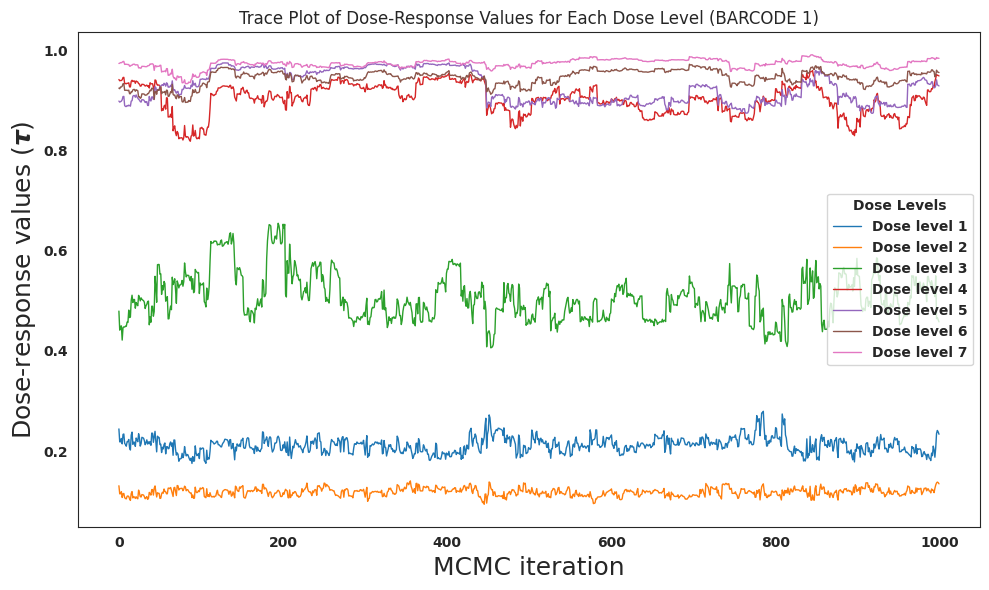

In [131]:
barcode_idx = 1
num_doses = Tau_s10.shape[2]
num_iterations = Tau_s10.shape[1]

with sns.axes_style('white', {'legend.frameon': True}):
    plt.figure(figsize=(10, 6))
    plt.rc('font', weight='bold')
    plt.rc('grid', lw=3)
    plt.rc('lines', lw=1)
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42

    # Plot Tau for each dose level across MCMC iterations for the selected barcode
    for dose_idx in range(num_doses):
        plt.plot(Tau_s10[barcode_idx, :, dose_idx], label=f'Dose level {dose_idx + 1}')

    plt.xlabel('MCMC iteration', fontsize=18)
    plt.ylabel('Dose-response values ($\\tau$)', fontsize=18)
    plt.title(f'Trace Plot of Dose-Response Values for Each Dose Level (BARCODE {barcode_idx})')
    plt.legend(title="Dose Levels")
    plt.tight_layout()

    # Save and show the plot
    plt.savefig(f'/content/trace_dose_levels_barcode_{barcode_idx}.pdf', bbox_inches='tight')
    plt.show()


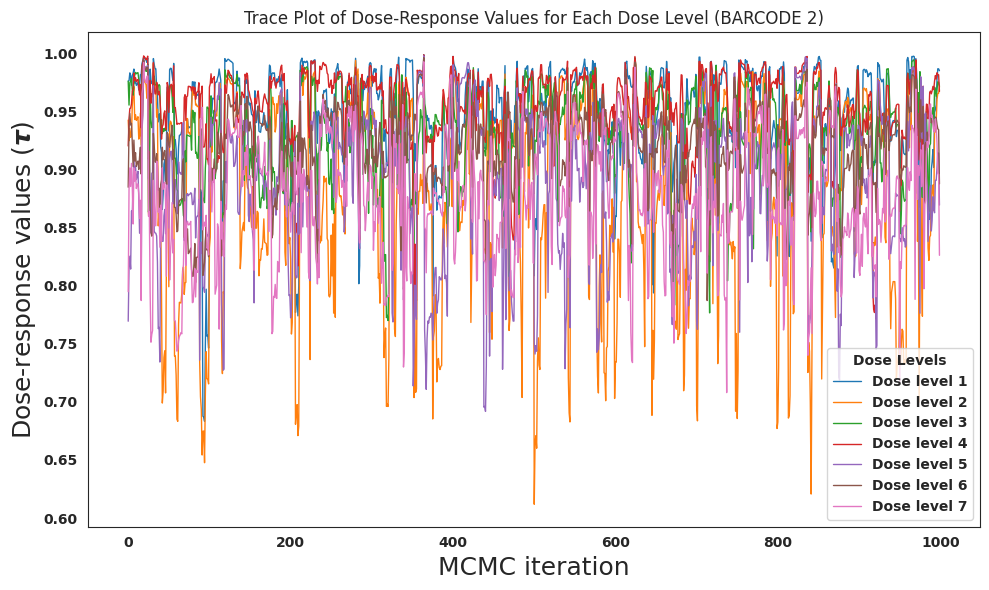

In [132]:
barcode_idx = 2
num_doses = Tau_s10.shape[2]
num_iterations = Tau_s10.shape[1]

with sns.axes_style('white', {'legend.frameon': True}):
    plt.figure(figsize=(10, 6))
    plt.rc('font', weight='bold')
    plt.rc('grid', lw=3)
    plt.rc('lines', lw=1)
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42

    # Plot Tau for each dose level across MCMC iterations for the selected barcode
    for dose_idx in range(num_doses):
        plt.plot(Tau_s10[barcode_idx, :, dose_idx], label=f'Dose level {dose_idx + 1}')

    plt.xlabel('MCMC iteration', fontsize=18)
    plt.ylabel('Dose-response values ($\\tau$)', fontsize=18)
    plt.title(f'Trace Plot of Dose-Response Values for Each Dose Level (BARCODE {barcode_idx})')
    plt.legend(title="Dose Levels")
    plt.tight_layout()

    # Save and show the plot
    plt.savefig(f'/content/trace_dose_levels_barcode_{barcode_idx}.pdf', bbox_inches='tight')
    plt.show()


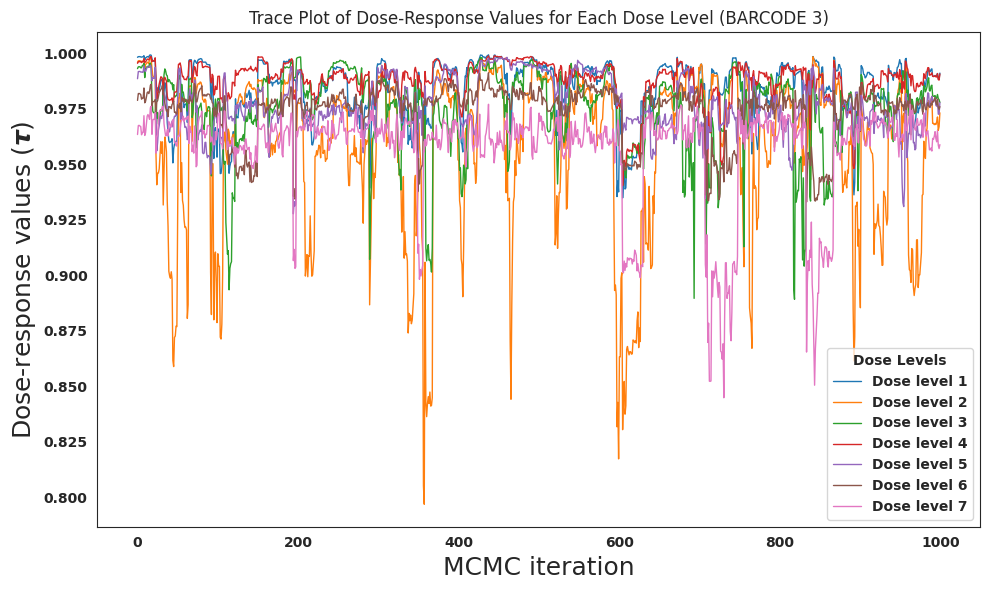

In [133]:
barcode_idx = 3
num_doses = Tau_s10.shape[2]
num_iterations = Tau_s10.shape[1]

with sns.axes_style('white', {'legend.frameon': True}):
    plt.figure(figsize=(10, 6))
    plt.rc('font', weight='bold')
    plt.rc('grid', lw=3)
    plt.rc('lines', lw=1)
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42

    # Plot Tau for each dose level across MCMC iterations for the selected barcode
    for dose_idx in range(num_doses):
        plt.plot(Tau_s10[barcode_idx, :, dose_idx], label=f'Dose level {dose_idx + 1}')

    plt.xlabel('MCMC iteration', fontsize=18)
    plt.ylabel('Dose-response values ($\\tau$)', fontsize=18)
    plt.title(f'Trace Plot of Dose-Response Values for Each Dose Level (BARCODE {barcode_idx})')
    plt.legend(title="Dose Levels")
    plt.tight_layout()

    # Save and show the plot
    plt.savefig(f'/content/trace_dose_levels_barcode_{barcode_idx}.pdf', bbox_inches='tight')
    plt.show()


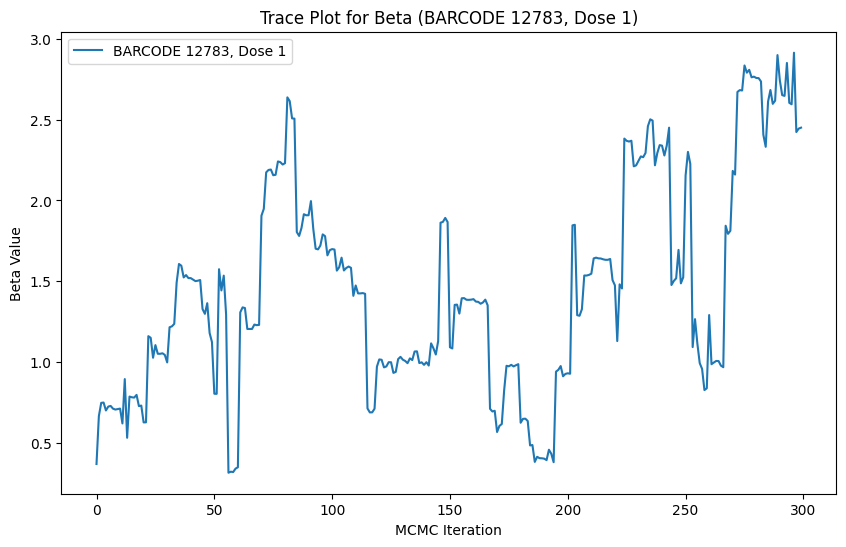

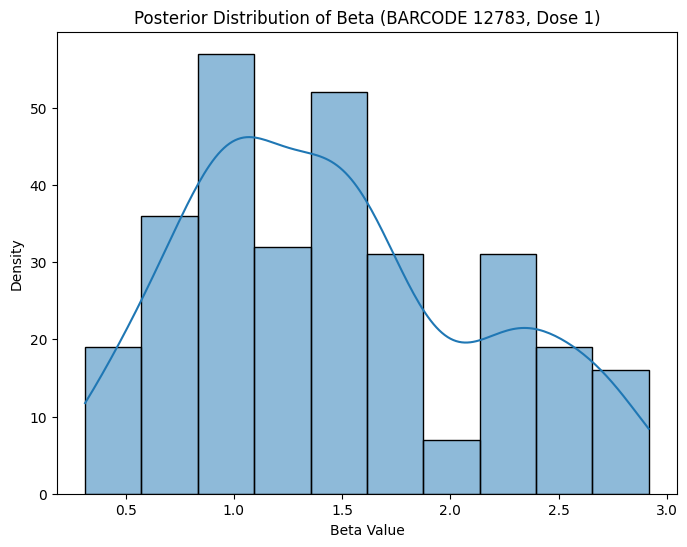

In [73]:
barcode_idx = 0
dose_idx = 0

plt.figure(figsize=(10, 6))
plt.plot(B_s10[barcode_idx, :, dose_idx], label=f"BARCODE {selected_barcodes[barcode_idx]}, Dose {dose_idx+1}")
plt.xlabel("MCMC Iteration")
plt.ylabel("Beta Value")
plt.title(f"Trace Plot for Beta (BARCODE {selected_barcodes[barcode_idx]}, Dose {dose_idx+1})")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(B_s10[barcode_idx, :, dose_idx], kde=True)
plt.xlabel("Beta Value")
plt.ylabel("Density")
plt.title(f"Posterior Distribution of Beta (BARCODE {selected_barcodes[barcode_idx]}, Dose {dose_idx+1})")
plt.show()


In [140]:
drug_ids_raw = list(set(raw_data.DRUG_ID.tolist()))
cosmic_ids_raw = list(set(raw_data.COSMIC_ID.tolist()))
def retrieve_dose_intensity_data(cosmic_id, drug_id):
    subset = raw_data[(raw_data["COSMIC_ID"] == cosmic_id) & (raw_data["DRUG_ID"] == drug_id)]
    subset_barcodes = set(subset["BARCODE"].values)
    data = []
    for barcode in subset_barcodes:
        further_subset = subset[subset["BARCODE"] == barcode]
        tags = further_subset["TAG"].values
        tags_passed = True
        dose_counts = [0] * 7
        for i, tag in enumerate(tags):
            if i % 7 == 0:
                for count in dose_counts: assert count == i // 7, "Doses not contiguous."
            split_tag = tag.split("-")
            if split_tag[0][0] != 'L' or split_tag[-1] != "S":
                tags_passed = False
                break
            dose_counts[int(split_tag[1][1]) - 1] += 1
        if not tags_passed: continue
        for count in dose_counts:
            assert count == dose_counts[0], f"Doses unevenly sampled for barcode {barcode}!"
        for i in range(dose_counts[0]):
            plate_data = {"barcode": barcode,
                         "seeding_density": further_subset["SEEDING_DENSITY"].iloc[0],
                         "dose": further_subset["CONC"].values[7*i:7*(i+1)],
                         "intensity": further_subset["INTENSITY"].values[7*i:7*(i+1)]}
            data.append(plate_data)
    return data

In [155]:
get_cell_line_and_drug_pairs(42030)

[('HCC1569', nan),
 ('HCC1569', 4000.0),
 ('HCC1569', 1034.0),
 ('HCC1569', 1862.0),
 ('HCC1569', 1003.0),
 ('HCC1569', 1021.0),
 ('HCC1569', 1060.0),
 ('HCC1569', 1372.0),
 ('HCC1569', 1050.0),
 ('HCC1569', 1022.0),
 ('HCC1569', 1073.0),
 ('HCC1569', 1053.0),
 ('HCC1569', 1190.0),
 ('HCC1569', 1192.0),
 ('HCC1569', 1007.0),
 ('HCC1569', 1051.0),
 ('HCC1569', 1558.0),
 ('HCC1569', 1925.0),
 ('HCC1569', 1561.0),
 ('HCC1569', 1083.0),
 ('HCC1569', 1179.0)]

In [174]:
import numpy as np
from scipy.stats import gamma, poisson

def beta_mcmc_for_drug(mu_hat, sigma_hat, a_prior, b_prior, c_prior, Y, BARCODE_list,
                       drug_id_of_interest, raw_data, nburn=500, nsamples=1000, nthin=1):

    # Step 1: Filter BARCODEs associated with the specified Drug_ID
    barcodes_for_drug = raw_data[raw_data['DRUG_ID'] == drug_id_of_interest]['BARCODE'].unique()
    indices_for_drug = [i for i, barcode in enumerate(BARCODE_list) if barcode in barcodes_for_drug]

    Beta_samples = []
    Sigma_samples = []
    Loglikelihood_samples = []
    count = 0
    for barcode_idx in indices_for_drug:
        barcode = BARCODE_list[barcode_idx]
        print(f'Processing BARCODE {barcode} (Drug_ID {drug_id_of_interest})')

        # Extract priors and observed data for the current BARCODE
        a = a_prior.loc[barcode, 'A']
        b = b_prior.loc[barcode, 'B']
        c = c_prior.loc[barcode, 'C']
        y_data = Y.loc[barcode].values

        lam_grid = gamma.rvs(a=a, scale=b, size=100)
        weights = gamma.pdf(lam_grid, a=a, scale=b)
        weights /= weights.sum()  # Normalize weights

        # Use provided mu_hat and sigma_hat
        Mu = mu_hat[barcode_idx]
        Sigma = sigma_hat

        # Initialize Beta with the mean Mu
        Beta = np.copy(Mu)

        # Prepare for MCMC
        barcode_Beta_samples = np.zeros((nsamples, len(Beta)))
        barcode_Sigma_samples = np.zeros((nsamples, Sigma.shape[0], Sigma.shape[1]))
        barcode_Loglikelihood_samples = np.zeros(nsamples)

        def log_likelihood(z):
            z = z[..., None]  # Expand for lambda grid
            lam = lam_grid[None, None]
            w = weights[None]
            y = y_data[None, :, None]
            return np.nansum(np.log((poisson.pmf(y, ilogit(z) * lam + c) * w).clip(1e-10, np.inf).sum(axis=-1)), axis=-1)

        # Initialize log likelihood and Cholesky decomposition
        Cur_log_likelihood = log_likelihood(Beta)
        chol_Sigma = np.linalg.cholesky(Sigma)

        # MCMC Sampling
        # MCMC Sampling
        for step in range(nburn + nsamples * nthin):
            # Apply elliptical slice sampling for the entire Beta vector
            Beta, Cur_log_likelihood = elliptical_slice(
                Beta,
                chol_Sigma,               # Cholesky decomposition of Sigma
                log_likelihood,           # Log-likelihood function
                cur_log_like=Cur_log_likelihood,
                mu=Mu                     # Mean vector for elliptical slice
            )

            # Save samples after burn-in and thinning
            if step >= nburn and (step - nburn) % nthin == 0:
                sample_idx = (step - nburn) // nthin
                barcode_Beta_samples[sample_idx] = Beta
                barcode_Sigma_samples[sample_idx] = Sigma
                barcode_Loglikelihood_samples[sample_idx] = Cur_log_likelihood


        # Store Beta, Sigma, and Loglikelihood samples for this BARCODE
        Beta_samples.append(barcode_Beta_samples)
        Sigma_samples.append(barcode_Sigma_samples)
        Loglikelihood_samples.append(barcode_Loglikelihood_samples)
        count+=1

    # Step 4: Combine all samples across BARCODEs for the specified Drug_ID
    Beta_samples_combined = np.concatenate(Beta_samples, axis=0)
    Sigma_samples_combined = np.concatenate(Sigma_samples, axis=0)
    Loglikelihood_samples_combined = np.concatenate(Loglikelihood_samples, axis=0)
    print("number of barcodes: ", count)

    # Return the combined samples for plotting or further analysis
    return Beta_samples_combined, Sigma_samples_combined, Loglikelihood_samples_combined


In [163]:
beta_d, sigma_d, LL_d = beta_mcmc_for_drug(np.array(mu_hat_df), sigma_hat, A_subset, B_subset, C_subset, Y_subset, selected_barcodes,
                                           1372, raw_data, nburn = 100, nsamples = 400, nthin=1)

Processing BARCODE 25359 (Drug_ID 1372)
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx siz

<ipython-input-161-7d6fb8f37f50>:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  barcode_Loglikelihood_samples[sample_idx] = Cur_log_likelihood


Streaming output truncated to the last 5000 lines.
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new 

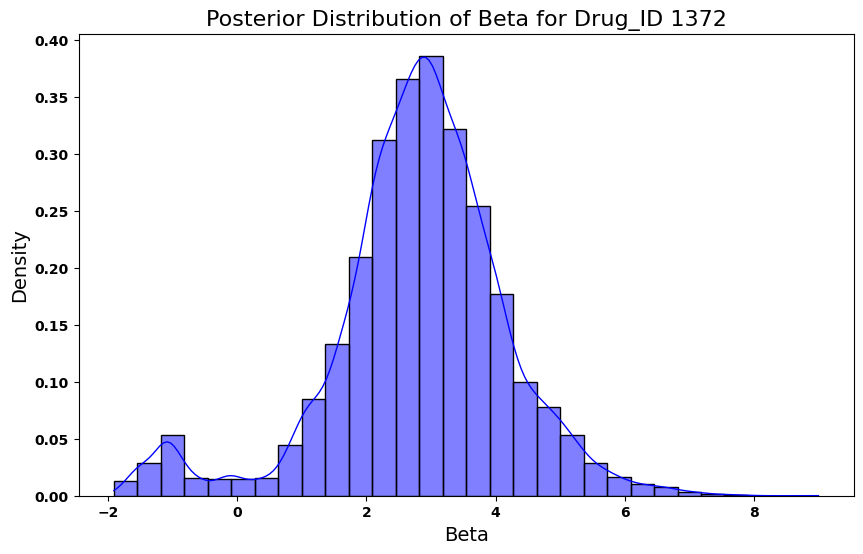

In [164]:
# Plot the posterior distribution of Beta
plt.figure(figsize=(10, 6))
sns.histplot(beta_d.flatten(), kde=True, bins=30, color='blue', edgecolor='black', stat='density')
plt.xlabel('Beta', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title(f'Posterior Distribution of Beta for Drug_ID {1372}', fontsize=16)
plt.show()

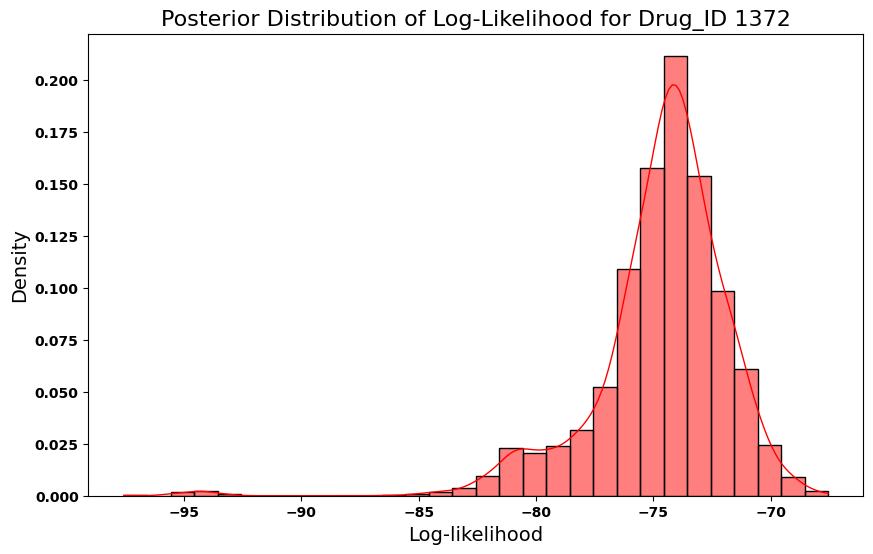

In [166]:
# Plot the posterior distribution of Loglikelihood
plt.figure(figsize=(10, 6))
sns.histplot(LL_d, kde=True, bins=30, color='red', edgecolor='black', stat='density')
plt.xlabel('Log-likelihood', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title(f'Posterior Distribution of Log-Likelihood for Drug_ID {1372}', fontsize=16)
plt.show()

In [167]:
tau_d = ilogit(beta_d)

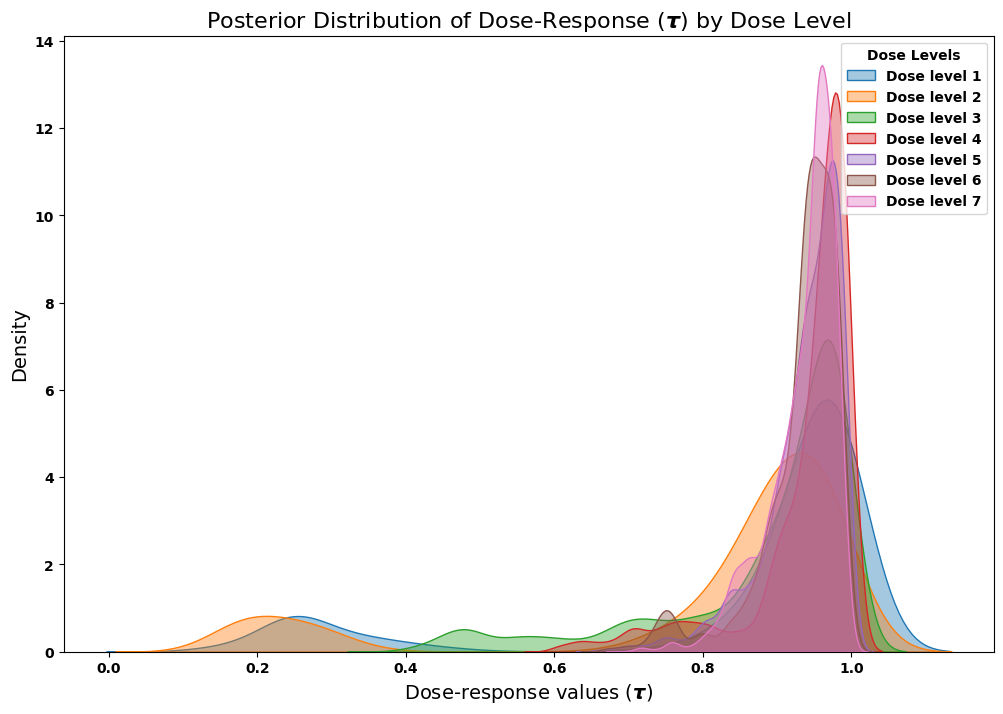

In [170]:
plt.figure(figsize=(12, 8))
dose_levels = tau_d.shape[1]  # Number of dose levels

for dose in range(dose_levels):
    sns.kdeplot(tau_d[:, dose], label=f'Dose level {dose + 1}', fill=True, alpha=0.4)

plt.xlabel('Dose-response values ($\\tau$)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Posterior Distribution of Dose-Response ($\\tau$) by Dose Level', fontsize=16)
plt.legend(title="Dose Levels")
plt.show()

In [184]:
beta_d, sigma_d, LL_d = beta_mcmc_for_drug(np.array(mu_hat_df), sigma_hat, A_subset, B_subset, C_subset, Y_subset, selected_barcodes,
                                           4000, raw_data, nburn = 500, nsamples = 1500, nthin=1)

Processing BARCODE 25359 (Drug_ID 4000)
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx siz

<ipython-input-174-7bde24714cc7>:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  barcode_Loglikelihood_samples[sample_idx] = Cur_log_likelihood


Streaming output truncated to the last 5000 lines.
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new beta
xx size:  (7,) prior size:  (7, 7)
Accepted new 

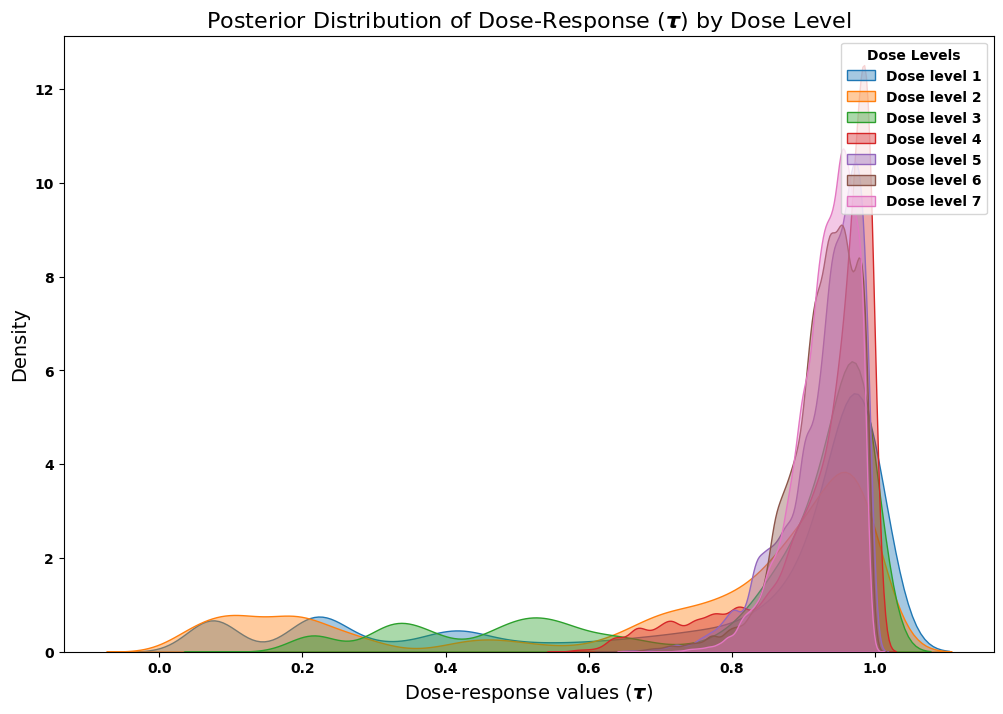

In [185]:
tau_d = ilogit(beta_d)
plt.figure(figsize=(12, 8))
dose_levels = tau_d.shape[1]  # Number of dose levels

for dose in range(dose_levels):
    sns.kdeplot(tau_d[:, dose], label=f'Dose level {dose + 1}', fill=True, alpha=0.4)

plt.xlabel('Dose-response values ($\\tau$)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Posterior Distribution of Dose-Response ($\\tau$) by Dose Level', fontsize=16)
plt.legend(title="Dose Levels")
plt.show()